In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sb
import csv
import os


%matplotlib inline

# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *Y*

**Names:**

* *Mateusz Paluchowski*
* *Kristian Aurlien*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

#### Notebook remarks

We believe that code should be self commenting and we followed this logic when doing this exercises.

Only some tricky parts are explained.

---

## 2.1 Exploration of real networks

#### Exercise 2.1

##### 1. Load the graph in your favorite data structure - NetworkX Graph

In [2]:
DATA_PATH = '../data/'

def load_graph(network_name):
    file_path = os.path.join(DATA_PATH, network_name)
    with open(file_path) as f:
        data=[tuple(line) for line in csv.reader(f)]
        
    # Drop the two first rows, containing headers 
    edge_list = data[2:]
    
    graph = nx.Graph(edge_list)
    
    return graph


G1 = load_graph('network1.csv')

##### 2. How many nodes and edges does the graph contain?

In [3]:
def describe_graph(graph):
    print(nx.info(graph))
    
describe_graph(G1)

Name: 
Type: Graph
Number of nodes: 13033
Number of edges: 18584
Average degree:   2.8518


#### Exercise 2.2:  Node degree distribution

#### 1. What kind of plot do you think is useful for this task?

We decided to go for two plots: 
    1. Regular log-log plot
    2. Cumulative log-log plot

In [4]:
def node_degree_distribution(graph):
    counts = Counter(graph.degree().values())
    degrees = sorted(counts.keys(), reverse=True)
    degree_counts = [counts[deg] for deg in degrees]
    cumsums = np.cumsum(degree_counts)
    
    print("The maximum degree is", max(degrees))

    plt.subplot(1, 2, 1)
    plt.title("Log-log distribution plot")
    plt.xlabel("Degree")
    plt.ylabel("# Nodes with degree x")
    plt.xlabel("degree")
    plt.loglog(degrees, degree_counts)
    
    plt.subplot(1, 2, 2)
    plt.title("Cumulative Log-log distribution plot")
    plt.xlabel("Degree")
    plt.ylabel("# Nodes with degree >= x")
    plt.xlabel("degree")
    plt.loglog(degrees, cumsums)
    
    plt.tight_layout()
    plt.show()
    
    return degrees, degree_counts, cumsums

The maximum degree is 1482


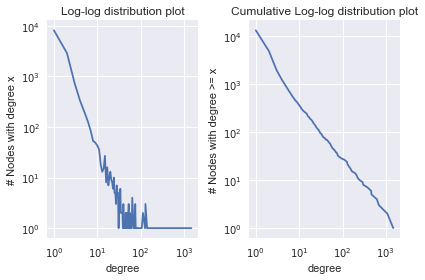

In [5]:
degrees, counts, cumsums = node_degree_distribution(G1)

##### 2. Can you list some of the properties of the degree distribution?

We can see from the linear log-log plot that the node degree distribution follows a power law.

Some of the properties with this distribution:

- "Winer takes all" - most nodes have few edges
- Long tail - a few nodes have lots of edges

##### 3. Is it close to a well-known probability distribution? If so, provide an estimation of its parameter(s)?

We expect the data to follow the pareto distribution. We try to fit a PDF to verify our assumptions:

In [6]:
data = [val for val in G1.degree().values()]

In [7]:
from scipy.stats import pareto

shape, loc, scale = pareto.fit(data, 1.)
print("Shape: {}, loc: {}, scale: {}".format(shape, loc, scale))

/Users/mateusz/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2289: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Shape: 5.36518173279357, loc: -3.3752240370065074, scale: 4.37522403681271


In [8]:
# exponential curve fitting
degrees = sorted(G1.degree().values(), reverse=True)
fit = np.polyfit(range(len(degrees)), np.log(degrees), 1, w=np.sqrt(degrees))
slope = fit[0]
slope

-0.00044645830772092144

#### Exercise 2.3: Giant component

##### 1. Count the number of connected components in network1. 
##### 2. Is there a giant component ? If so, what is its size?

In [9]:
def describe_connected_components(graph):
    # get the connected components
    ccomps = sorted(nx.connected_components(graph), \
                                  key = len, reverse=True)
    n_ccomps = len(ccomps)
    print("There are {} connected components in the graph\n".format(n_ccomps))
    
    # Calculate the sizes of the connected components
    ccomp_sizes = list(map(lambda x: len(x), ccomps))
    
    above_limit = len(ccomp_sizes) > 15
    
    if len(ccomp_sizes) > 15:
        print("The sizes of the 15 biggest connected components are:")
    else:
        print("The sizes of the connected components are:")
    print(ccomp_sizes[:15])

In [10]:
describe_connected_components(G1)

There are 192 connected components in the graph

The sizes of the 15 biggest connected components are:
[12576, 16, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3]


We observe one giant component in the graph, which is of size 12576

#### Exercise 2.4: Short paths & Small-worlds

##### What is the distribution of path lengths between any two nodes in the network?

In [11]:
def small_world(graph):
    ccomps = sorted(nx.connected_components(graph), \
                                  key = len, reverse=True)
    
    giant_component = graph.subgraph(ccomps[0])
    avg_shortest_paths = nx.average_shortest_path_length(giant_component)
    
    print("The average shortest path is", avg_shortest_paths)

In [12]:
small_world(G1)

The average shortest path is 4.175488076629283


###### How fast is the network growing? I.e. what is the average number of nodes reachable within a distance r (in number of hops) of any other node in the network?

In [13]:
def network_growth(G, random_node, cutoff = 6):
    neighbors_count = [1] #root
    root = [random_node]
    neighbors = []
    while True:
        if len(neighbors_count) > cutoff:
            break
        for node in root:
            neighbors += G.neighbors(node)
        if not neighbors:
            break
        neighbors_count += [len(neighbors)]
        root = neighbors
        neighbors = []
        
        
    plt.figure()
    plt.semilogy(neighbors_count)
    plt.title("Network growth")
    plt.ylabel("No of neighbors")
    plt.xlabel("depth")

    
    return neighbors_count

In [14]:
ccomps = sorted(nx.connected_components(G1), key = len, reverse=True)
giant = list(ccomps[0])
np.random.seed(1)
random_node_from_giant = np.random.choice(giant)
distance = 6

[1, 2, 174, 6249, 176789, 11137072, 327317136]

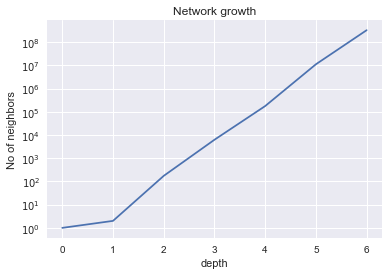

In [15]:
network_grw = network_growth(G1, random_node_from_giant, distance)
network_grw

Conducted test seem to verify that indeed network1 is a small-world. Not only the average shortes path to is 4.17, but also we can see that network growths exponentialy with each step with the slope:

In [16]:
fit = np.polyfit(range(len(network_grw)), np.log(network_grw), 1, w=np.sqrt(network_grw))
slope = fit[0]
slope

3.4048920359374986

#### Exercise 2.5: Network comparison

In [17]:
G2 = load_graph('network2.csv')

##### 1. Using the properties computed in Exercises 2.1, 2.2, 2.3 and 2.4 explore the structure of this network.

In [18]:
describe_graph(G2)

Name: 
Type: Graph
Number of nodes: 26542
Number of edges: 43516
Average degree:   3.2790


The maximum degree is 8


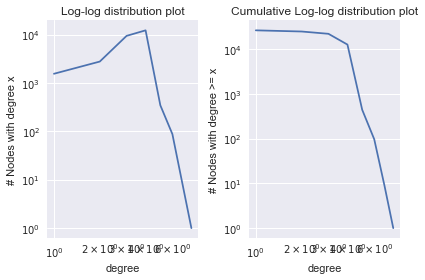

In [19]:
_ = node_degree_distribution(G2)

In [20]:
describe_connected_components(G2)

There are 5 connected components in the graph

The sizes of the connected components are:
[26481, 30, 24, 5, 2]


In [21]:
small_world(G2)

The average shortest path is 97.55708682597601


In [22]:
ccomps = sorted(nx.connected_components(G2),key = len, reverse=True)
giant = list(ccomps[0])
np.random.seed(1)
random_node = np.random.choice(giant)
distance = 6

[1, 3, 7, 17, 41, 101, 249]

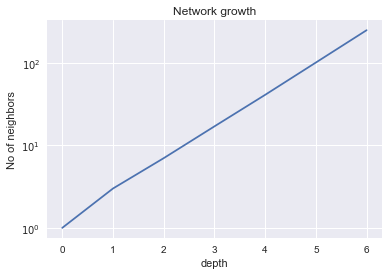

In [23]:
network_grw = network_growth(G2, random_node, 6)
network_grw

In [24]:
fit = np.polyfit(range(len(network_grw)), np.log(network_grw), 1, w=np.sqrt(network_grw))
slope = fit[0]
slope

0.89683141091023066

Network2 cannot be called small-world simply due to extensive average shortest paths which is 97.55.

##### 2. How does this network differ from the previous one?
 
###### Network1
('Number of nodes:', 13033)

('Number of edges:', 18584)

('The maximum degree is', 1482)

('The average degree is', 2.85)

There are 192 connected components in the graph
The sizes of the 15 biggest connected components are:
[12576, 16, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3]

We observe one giant component in the graph, which is of size 12576

('The average shortest path is', 4.175488076629283)

Network growth
[1, 2, 28, 1088, 33121, 1670996, 59644788]

###### Network2
('Number of nodes:', 26542)

('Number of edges:', 43516)

('The maximum degree is', 8)

(The average degree is 3.28)

There are 5 connected components in the graph
The sizes of the connected components are:
[26481, 30, 24, 5, 2]

('The average shortest path is', 97.55708682597601)

Network growth:
[1, 4, 16, 61, 242, 929, 3682]

Network2 is far less connected than network1. Even though it has double the amount of nodes and triple the amount of edges and average node degree is higher, the average shortest paths differ significantly (almost 20x longer average shortest path for network2 than for network1).

#### Exercise 2.6: Network identification

In the first network, the highest degree of a node is 1482, while in the second network the highest degree is 8. It is therefore reasonable to expect the second one to be the New York road network, and that the first network is the internet routers.